In [102]:
import matplotlib.pyplot as plt
import numpy as np

In [103]:
SRC_DIR = '../../clone-shim/'                        # void orchestrator repository
SHIM    = SRC_DIR+'target/release/void-orchestrator' # void orchestrator binary

In [104]:
!mkdir -p output/

In [105]:
import tempfile

def performance_test(bin, args=[], n=10):
    with tempfile.TemporaryDirectory() as workdir:
        src = workdir+'/src.c'
        out = workdir+'/bin'

        args.insert( 0, bin)
        args = ','.join(['"{}"'.format(x) for x in args])

        with open(src, 'w') as src_file:
            src_file.write('''
#include <fcntl.h>
#include <stdint.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/wait.h>
#include <time.h>
#include <unistd.h>

static const char BIN[] = "''' + bin + '''";
static char* ARGS[] = {''' + args + '''};

void print_diff(int fd, struct timespec *t1, struct timespec *t2) {
    struct timespec d = {
        .tv_sec = t2->tv_sec - t1->tv_sec,
        .tv_nsec = t2->tv_nsec - t1->tv_nsec,
    };

    if (d.tv_nsec < 0) {
        d.tv_nsec += 1000000000;
        d.tv_sec--;
    }

    dprintf(fd, "%10jd.%09ld\\n", (intmax_t) d.tv_sec, d.tv_nsec);
}

int main(int argc, char **argv) {
    int new_stdout, nullfd, exitcode;
    struct timespec t1, t2;
    long repeats;
    int wstatus;

    // silence default output
    new_stdout = dup(1);
    nullfd = open("/dev/null", O_WRONLY);
    dup2(nullfd, 1);
    dup2(nullfd, 2);

    repeats = strtol(argv[1], NULL, 10);

    for (long i = 0; i < repeats; i++) {
        if (clock_gettime(CLOCK_MONOTONIC, &t1) == -1) {
            perror("clock_gettime");
            exit(EXIT_FAILURE);
        }

        if (vfork() == 0) {
            if (execv(BIN, ARGS) == -1) {
                perror("execv");
                return -1;
            }
        }

        wait(&wstatus);

        if (clock_gettime(CLOCK_MONOTONIC, &t2) == -1) {
            perror("clock_gettime");
            exit(EXIT_FAILURE);
        }

        exitcode = WEXITSTATUS(wstatus);
        if (exitcode) {
            exit(exitcode);
        }

        print_diff(new_stdout, &t1, &t2);
    }
}
''')
            src_file.flush()

        !clang -o {out} {src}
        results = !{out} {n}
        times = [float(s.strip()) for s in results]
        return times


## Startup costs

Evaluate the startup costs of applications.

### Evaluating the raw calls

In [106]:
import itertools

CLONE_FLAGS = sorted(['CLONE_NEWUTS', 'CLONE_NEWPID', 'CLONE_NEWCGROUP', 'CLONE_NEWIPC', 'CLONE_NEWUSER', 'CLONE_NEWNS', 'CLONE_NEWNET'])
runs = 1250

# warm up with a tonne of clone calls
with tempfile.TemporaryDirectory() as workdir:
    src = workdir+'/src.c'
    out = workdir+'/bin'

    with open(src, 'w') as src_file:
        src_file.write('''
#define _GNU_SOURCE
#include <unistd.h>
#include <sched.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/syscall.h>
#include <sys/wait.h>

int main() {
    long child_pid;
    int wstatus;

    for (int i = 0; i < ''' + str(runs) + '''; i++) {
        child_pid = syscall(SYS_clone, SIGCHLD, NULL, NULL, NULL, 0);

        if (child_pid == 0) {
            return 0;
        } else if (child_pid == -1) {
            perror("clone");
            return -1;
        }

        wait(&wstatus);
    }

    return 0;
}
''')
        src_file.flush()

    !clang -o {out} {src}
    for i in range(10):
        print("warming up: {}/10".format(i))
        !{out}

clone_timings = {}
for flags in itertools.chain.from_iterable([itertools.combinations(CLONE_FLAGS, i) for i in range(len(CLONE_FLAGS)+1)]):
    test_name = '|'.join(flags)

    with tempfile.TemporaryDirectory() as workdir:
        src = workdir+'/src.c'
        out = workdir+'/bin'

        with open(src, 'w') as src_file:
            src_file.write('''
#define _GNU_SOURCE
#include <unistd.h>
#include <stdint.h>
#include <sched.h>
#include <stdio.h>
#include <stdlib.h>
#include <sys/syscall.h>
#include <sys/wait.h>
#include <time.h>

static const int FLAGS = ''' + '|'.join(flags if flags else ['0']) + ''';

void print_diff(struct timespec *t1, struct timespec *t2) {
    struct timespec d = {
        .tv_sec = t2->tv_sec - t1->tv_sec,
        .tv_nsec = t2->tv_nsec - t1->tv_nsec,
    };

    if (d.tv_nsec < 0) {
        d.tv_nsec += 1000000000;
        d.tv_sec--;
    }

    printf("%10jd.%09ld\\n", (intmax_t) d.tv_sec, d.tv_nsec);
}

int main() {
    struct timespec t1, t2;
    long child_pid;
    int wstatus;

    for (int i = 0; i < ''' + str(runs) + '''; i++) {
        if (clock_gettime(CLOCK_MONOTONIC, &t1) == -1) {
            perror("clock_gettime");
            exit(EXIT_FAILURE);
        }

        child_pid = syscall(SYS_clone, FLAGS | SIGCHLD, NULL, NULL, NULL, 0);

        if (child_pid == 0) {
            return 0;
        } else if (child_pid == -1) {
            perror("clone");
            return -1;
        }

        wait(&wstatus);

        if (clock_gettime(CLOCK_MONOTONIC, &t2) == -1) {
            perror("clock_gettime");
            exit(EXIT_FAILURE);
        }

        print_diff(&t1, &t2);
    }

    return 0;
}
''')
            src_file.flush()

        print('benchmarking: '+test_name)
        !clang -o {out} {src}
        results = !{out}
        clone_timings[test_name] = [float(s.strip()) for s in results[(int(runs/20)):]]

warming up: 0/10
warming up: 1/10
warming up: 2/10
warming up: 3/10
warming up: 4/10
warming up: 5/10
warming up: 6/10
warming up: 7/10
warming up: 8/10
warming up: 9/10
benchmarking: 
benchmarking: CLONE_NEWCGROUP
benchmarking: CLONE_NEWIPC
benchmarking: CLONE_NEWNET
benchmarking: CLONE_NEWNS
benchmarking: CLONE_NEWPID
benchmarking: CLONE_NEWUSER
benchmarking: CLONE_NEWUTS
benchmarking: CLONE_NEWCGROUP|CLONE_NEWIPC
benchmarking: CLONE_NEWCGROUP|CLONE_NEWNET
benchmarking: CLONE_NEWCGROUP|CLONE_NEWNS
benchmarking: CLONE_NEWCGROUP|CLONE_NEWPID
benchmarking: CLONE_NEWCGROUP|CLONE_NEWUSER
benchmarking: CLONE_NEWCGROUP|CLONE_NEWUTS
benchmarking: CLONE_NEWIPC|CLONE_NEWNET
benchmarking: CLONE_NEWIPC|CLONE_NEWNS
benchmarking: CLONE_NEWIPC|CLONE_NEWPID
benchmarking: CLONE_NEWIPC|CLONE_NEWUSER
benchmarking: CLONE_NEWIPC|CLONE_NEWUTS
benchmarking: CLONE_NEWNET|CLONE_NEWNS
benchmarking: CLONE_NEWNET|CLONE_NEWPID
benchmarking: CLONE_NEWNET|CLONE_NEWUSER
benchmarking: CLONE_NEWNET|CLONE_NEWUTS
bench

In [107]:
# sort the flags by median creation time for better comparison when displayed
ordered_flags = sorted(CLONE_FLAGS, key=lambda x: np.median(clone_timings[x]), reverse=False)

[np.median(clone_timings[x]) for x in ordered_flags]
ordered_flags

['CLONE_NEWPID',
 'CLONE_NEWCGROUP',
 'CLONE_NEWUTS',
 'CLONE_NEWUSER',
 'CLONE_NEWIPC',
 'CLONE_NEWNS',
 'CLONE_NEWNET']

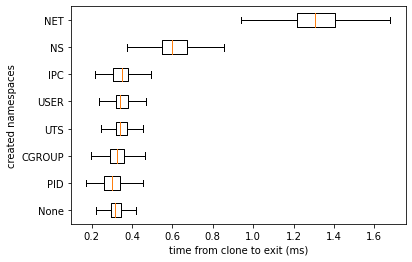

In [129]:
# plot creation of just each namespace with clone
flags = [''] + ordered_flags

x = [clone_timings[flag] for flag in flags]
x = [[1000*t for t in y] for y in x]

labels = [x.replace('CLONE_NEW', '') for x in flags]
labels[0] = 'None'

plt.boxplot(x, labels=labels, vert=False, showfliers=False)
plt.xlabel('time from clone to exit (ms)')
plt.ylabel('created namespaces')

plt.savefig('output/clone_individual_namespaces.png')
plt.show()

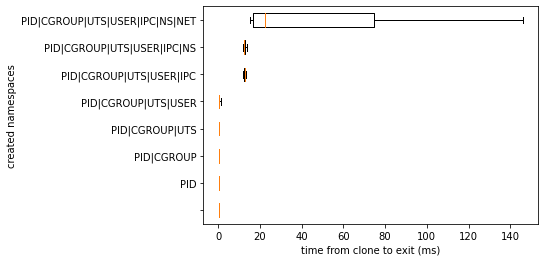

In [130]:
# plot creation of adding more namespaces each time
growing_flags = ['|'.join(ordered_flags[0:i]) for i in range(len(ordered_flags)+1)]

x = [clone_timings['|'.join(sorted(flags.split('|')))] for flags in growing_flags]
x = [[1000*t for t in y] for y in x]

labels = [x.replace('CLONE_NEW', '') for x in growing_flags]

plt.boxplot(x, labels=labels, vert=False, showfliers=False)
plt.xlabel('time from clone to exit (ms)')
plt.ylabel('created namespaces')

plt.savefig('output/clone_stacked_namespaces.png')
plt.show()

### Evaluating Fib

In [110]:
FIB      = SRC_DIR+'target/release/examples/fib'
FIB_SPEC = SRC_DIR+'examples/fib/spec.json'

import time

In [111]:
raw_fib_times = performance_test(FIB, n=1000)


In [112]:
shimmed_fib_times = performance_test(SHIM, ['-s', FIB_SPEC, FIB], n=1000)


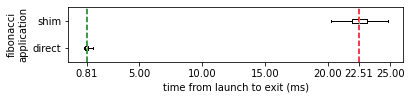

In [128]:
x = [[1000*x for x in raw_fib_times], [1000*x for x in shimmed_fib_times]]
labels = ['direct', 'shim']

plt.figure(figsize=(6, 1))
plt.boxplot(x, labels=labels, vert=False, showfliers=False)
plt.xlabel('time from launch to exit (ms)')
plt.ylabel('fibonacci\napplication')

raw_median = np.median([raw_fib_times])
shimmed_median = np.median([shimmed_fib_times])

plt.xticks([5,10,15,20,25,raw_median*1000,shimmed_median*1000])
plt.axvline(x=raw_median*1000, label='synced > auto', linestyle='--', color='green')
plt.axvline(x=shimmed_median*1000, label='synced peak', linestyle='--', color='red')

plt.savefig('output/fib_startup.png')
plt.show()

### Evaluating TLS

In [8]:
TLS_SERVER      = SRC_DIR+'target/release/examples/tls'
TLS_SERVER_SPEC = SRC_DIR+'examples/tls/spec.json'

APACHE_PORT = 443
VOID_PORT   = 8443

import subprocess
import os
import time
import signal
import tempfile

In [153]:
def apache_benchmark(url, t=10, c=100):
    _, name = tempfile.mkstemp(suffix='.csv')

    #cmd_output = !ab -e {name} -c 100 -t 10 {url}
    #if _exit_code != 0:
        #raise Exception('bad exit status')
        
    process = subprocess.Popen(['/usr/bin/ab', '-e', name, '-c', str(c), '-t', str(t), url],
                               stdout=subprocess.DEVNULL, stderr= subprocess.DEVNULL)
    process.wait(t+5)
    
    # input(f'ab -e {name} -c 100 -t 10 {url}')
    with open(name, "r") as f:
        split_lines = [l.split(',') for l in f.readlines()]
        split_lines = split_lines[1:]
        
        output = { int(s[0]): float(s[1]) for s in split_lines }
        for i in range(101):
            assert i in output
        return output


In [143]:
file_sizes = [2**i for i in range(13, 25)]

for size in file_sizes:
    with open('/var/www/html/{}.bin'.format(size), 'wb') as f:
        while size > 0:
            to_write = 4096 if size > 4096 else size
            f.write(os.urandom(to_write))
            size -= to_write


In [98]:
# benchmark Apache2 TLS server

apache_results = {}
for size in file_sizes:
    print(f'benchmarking size {size}')
    apache_results[size] = apache_benchmark(f'https://localhost:{APACHE_PORT}/{size}.bin')
    

benchmarking size 8192
benchmarking size 16384
benchmarking size 32768
benchmarking size 65536
benchmarking size 131072
benchmarking size 262144
benchmarking size 524288
benchmarking size 1048576
benchmarking size 2097152
benchmarking size 4194304
benchmarking size 8388608
benchmarking size 16777216


In [152]:
# benchmark handmade TLS server (complete privilege separation)

def kill_tls_server():
    !pkill --signal SIGINT 'void-orchestrat|entrypoint|connection_list|tls_handler|http_handler'
    time.sleep(2)
    !pkill --signal SIGKILL 'void-orchestrat|entrypoint|connection_list|tls_handler|http_handler'
    time.sleep(1)

void_results = {}
for size in file_sizes:
    print(f'benchmarking size {size}')

    for i in range(5):
        kill_tls_server()
        process = subprocess.Popen([SHIM, '-D', '-s', TLS_SERVER_SPEC, TLS_SERVER])
        if process.wait(5) == 0:
            break
    else:
        raise Exception('failed to start server 5 times')

    void_results[size] = apache_benchmark(f'https://localhost:{VOID_PORT}/{size}.bin')
    
kill_tls_server()


benchmarking size 8192
This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


Finished 954 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /8192.bin
Document Length:        8192 bytes

Concurrency Level:      100
Time taken for tests:   10.000 seconds
Complete requests:      954
Failed requests:        0
Total transferred:      7854282 bytes
HTML transferred:       7815168 bytes
Requests per second:    95.40 [#/sec] (mean)
Time per request:       1048.244 [ms] (mean)
Time per request:       10.482 [ms] (mean, across all concurrent requests)
Transfer rate:          767.00 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       25  855 259.1    902    1277
Processing:    21  115  51.8    116     238
Waiting:       13  115  51.8    116     237
Total:         56  970 270.4    983    1452

Percentage of the requests served wi

Finished 698 requests


This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


Finished 285 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /32768.bin
Document Length:        32768 bytes

Concurrency Level:      100
Time taken for tests:   10.006 seconds
Complete requests:      285
Failed requests:        0
Total transferred:      9350850 bytes
HTML transferred:       9338880 bytes
Requests per second:    28.48 [#/sec] (mean)
Time per request:       3510.918 [ms] (mean)
Time per request:       35.109 [ms] (mean, across all concurrent requests)
Transfer rate:          912.61 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       37 2726 957.7   3186    3544
Processing:    34  178  59.3    184     311
Waiting:       27  177  59.6    183     311
Total:         86 2903 972.0   3324    3798

Percentage of the requests served 

Finished 779 requests


This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


Finished 1109 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /131072.bin
Document Length:        131072 bytes

Concurrency Level:      100
Time taken for tests:   10.007 seconds
Complete requests:      1109
Failed requests:        0
Total transferred:      145406535 bytes
HTML transferred:       145358848 bytes
Requests per second:    110.83 [#/sec] (mean)
Time per request:       902.319 [ms] (mean)
Time per request:       9.023 [ms] (mean, across all concurrent requests)
Transfer rate:          14190.32 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:        9  606 145.9    651     814
Processing:     9  245 180.1    190     610
Waiting:        5  244 180.2    189     610
Total:         28  850 173.0    892    1130

Percentage of the requests

Finished 812 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /262144.bin
Document Length:        262144 bytes

Concurrency Level:      100
Time taken for tests:   10.004 seconds
Complete requests:      812
Failed requests:        0
Total transferred:      213014628 bytes
HTML transferred:       212979669 bytes
Requests per second:    81.17 [#/sec] (mean)
Time per request:       1232.010 [ms] (mean)
Time per request:       12.320 [ms] (mean, across all concurrent requests)
Transfer rate:          20794.05 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       12  910 218.1    938    1875
Processing:    20  138  53.4    143     341
Waiting:        7  136  53.5    142     340
Total:         32 1048 244.6   1062    2169

Percentage of the requests

Finished 264 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /524288.bin
Document Length:        524288 bytes

Concurrency Level:      100
Time taken for tests:   10.039 seconds
Complete requests:      264
Failed requests:        0
Total transferred:      138423384 bytes
HTML transferred:       138412032 bytes
Requests per second:    26.30 [#/sec] (mean)
Time per request:       3802.511 [ms] (mean)
Time per request:       38.025 [ms] (mean, across all concurrent requests)
Transfer rate:          13465.89 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       56 2700 840.5   2737    3891
Processing:    23  286 172.0    202     597
Waiting:       21  283 171.7    199     594
Total:        128 2985 937.4   3061    4483

Percentage of the requests

Finished 319 requests


This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


Finished 207 requests




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /2097152.bin
Document Length:        2097152 bytes

Concurrency Level:      100
Time taken for tests:   10.004 seconds
Complete requests:      207
Failed requests:        0
Total transferred:      434422720 bytes
HTML transferred:       434413568 bytes
Requests per second:    20.69 [#/sec] (mean)
Time per request:       4832.648 [ms] (mean)
Time per request:       48.326 [ms] (mean, across all concurrent requests)
Transfer rate:          42408.90 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       42 3631 1521.1   4247    5204
Processing:    52  214  59.9    215     372
Waiting:       29  203  60.0    205     364
Total:         95 3845 1508.8   4465    5438

Percentage of the requ

SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00CE35E2327F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:




Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /4194304.bin
Document Length:        4194304 bytes

Concurrency Level:      100
Time taken for tests:   10.004 seconds
Complete requests:      567
Failed requests:        6
   (Connect: 0, Receive: 0, Length: 6, Exceptions: 0)
Total transferred:      2378613196 bytes
HTML transferred:       2378588160 bytes
Requests per second:    56.68 [#/sec] (mean)
Time per request:       1764.421 [ms] (mean)
Time per request:       17.644 [ms] (mean, across all concurrent requests)
Transfer rate:          232187.32 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       34 1511 615.2   1249    3327
Processing:    36  124  56.6    114     406
Waiting:       15  107  55.9     98     393
Total:      

Finished 567 requests


This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
001E6FD7AA7F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn



Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /8388608.bin
Document Length:        8388608 bytes

Concurrency Level:      100
Time taken for tests:   10.003 seconds
Complete requests:      719
Failed requests:        29
   (Connect: 0, Receive: 0, Length: 29, Exceptions: 0)
Total transferred:      6019382384 bytes
HTML transferred:       6019350528 bytes
Requests per second:    71.88 [#/sec] (mean)
Time per request:       1391.219 [ms] (mean)
Time per request:       13.912 [ms] (mean, across all concurrent requests)
Transfer rate:          587662.12 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       11 1142 249.5   1219    1311
Processing:    24  141  27.9    141     227
Waiting:        7   99  26.1     99     173
Total:    

Finished 719 requests


This is ApacheBench, Version 2.3 <$Revision: 1879490 $>
Copyright 1996 Adam Twiss, Zeus Technology Ltd, http://www.zeustech.net/
Licensed to The Apache Software Foundation, http://www.apache.org/

Benchmarking localhost (be patient)


SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000197:SSL routines:SSL_shutdown:shutdown while in init:../ssl/ssl_lib.c:2244:
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000197:SSL routines:SSL_shutdown:shutdown while in init:../ssl/ssl_lib.c:2244:
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SS

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn

SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing connection
00EE1B1E267F0000:error:0A000126:SSL routines:ssl3_read_n:unexpected eof while reading:../ssl/record/rec_layer_s3.c:308:
SSL read failed (1) - closing conn



Server Software:        
Server Hostname:        localhost
Server Port:            8443
SSL/TLS Protocol:       TLSv1.2,ECDHE-ECDSA-AES256-GCM-SHA384,256,256
Server Temp Key:        X25519 253 bits
TLS Server Name:        localhost

Document Path:          /16777216.bin
Document Length:        16777216 bytes

Concurrency Level:      100
Time taken for tests:   10.006 seconds
Complete requests:      809
Failed requests:        800
   (Connect: 0, Receive: 0, Length: 800, Exceptions: 0)
Total transferred:      6926372450 bytes
HTML transferred:       6926335955 bytes
Requests per second:    80.85 [#/sec] (mean)
Time per request:       1236.846 [ms] (mean)
Time per request:       12.368 [ms] (mean, across all concurrent requests)
Transfer rate:          675992.02 [Kbytes/sec] received

Connection Times (ms)
              min  mean[+/-sd] median   max
Connect:       11  979 214.0   1050    1180
Processing:    23  178  48.8    175     334
Waiting:        7   80  33.5     73     159
Total:

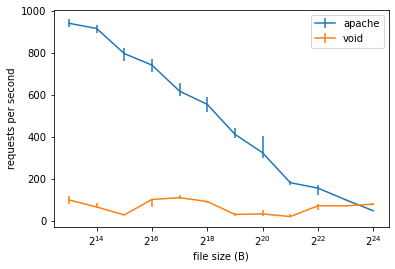

In [154]:
# plot results

def prep_graph(results):
    x_coords = []
    y_coords = []
    low_errs = []
    high_errs = []
    
    for size in file_sizes:
        x_coords.append(size)
        
        median = 1000 * 100 / results[size][50]
        q1 = 1000 * 100 / results[size][25]
        q3 = 1000 * 100 / results[size][75]
        
        y_coords.append(median)
        low_errs.append(median - q1)
        high_errs.append(q3 - median)
    
    return x_coords, y_coords, low_errs, high_errs

fig1, ax = plt.subplots()

apache_x_coords, apache_y_coords, apache_low_errs, apache_high_errs = prep_graph(apache_results)
ax.errorbar(apache_x_coords, apache_y_coords, [apache_low_errs, apache_high_errs], label='apache')

void_x_coords, void_y_coords, void_low_errs, void_high_errs = prep_graph(void_results)
ax.errorbar(void_x_coords, void_y_coords, [void_low_errs, void_high_errs], label='void')

ax.set_xscale('log', base=2)

ax.set_xlabel('file size (B)')
ax.set_ylabel('requests per second')

legend = ax.legend()

plt.savefig('output/tls_performance.png')
plt.show()


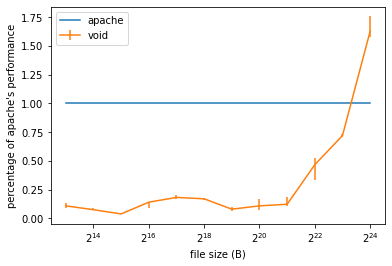

In [155]:
# plot results

def prep_graph(results):
    x_coords = []
    y_coords = []
    low_errs = []
    high_errs = []
    
    for size in file_sizes:
        x_coords.append(size)
        
        apache_median = apache_results[size][50]
        median = apache_median / results[size][50]
        q1 = apache_median / results[size][25]
        q3 = apache_median / results[size][75]
        
        y_coords.append(median)
        low_errs.append(median - q1)
        high_errs.append(q3 - median)
    
    return x_coords, y_coords, low_errs, high_errs

fig1, ax = plt.subplots()

apache_x_coords, apache_y_coords, apache_low_errs, apache_high_errs = prep_graph(apache_results)
 # no error in percentage of apache's performance for apache
ax.errorbar(apache_x_coords, apache_y_coords, label='apache')

void_x_coords, void_y_coords, void_low_errs, void_high_errs = prep_graph(void_results)
ax.errorbar(void_x_coords, void_y_coords, [void_low_errs, void_high_errs], label='void')

ax.set_xscale('log', base=2)

ax.set_xlabel('file size (B)')
ax.set_ylabel('percentage of apache\'s performance')

legend = ax.legend()

plt.savefig('output/tls_relative_performance.png')
plt.show()
